**Chapter 19 – Training and Deploying TensorFlow Models at Scale**

_This notebook contains all the sample code in chapter 19._

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/ageron/handson-ml2/blob/master/19_training_and_deploying_at_scale.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

# Setup
First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.


In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    !echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" > /etc/apt/sources.list.d/tensorflow-serving.list
    !curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | apt-key add -
    !apt update && apt-get install -y tensorflow-model-server
    !pip install -q -U tensorflow-serving-api
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deploy"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

No GPU was detected. CNNs can be very slow without a GPU.


# Deploying TensorFlow models to TensorFlow Serving (TFS)
We will use the REST API or the gRPC API.

## Save/Load a `SavedModel`

In [2]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()
X_train_full = X_train_full[..., np.newaxis].astype(np.float32) / 255.
X_test = X_test[..., np.newaxis].astype(np.float32) / 255.
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_new = X_test[:3]

In [3]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28, 1]),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-2),
              metrics=["accuracy"])
model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 2s 40us/sample - loss: 0.7018 - accuracy: 0.8223 - val_loss: 0.3722 - val_accuracy: 0.9022
Epoch 2/10
55000/55000 [==============================] - 2s 36us/sample - loss: 0.3528 - accuracy: 0.9021 - val_loss: 0.3000 - val_accuracy: 0.9170
Epoch 3/10
55000/55000 [==============================] - 2s 36us/sample - loss: 0.3032 - accuracy: 0.9150 - val_loss: 0.2659 - val_accuracy: 0.9280
Epoch 4/10
55000/55000 [==============================] - 2s 37us/sample - loss: 0.2730 - accuracy: 0.9233 - val_loss: 0.2442 - val_accuracy: 0.9342
Epoch 5/10
55000/55000 [==============================] - 2s 37us/sample - loss: 0.2504 - accuracy: 0.9305 - val_loss: 0.2272 - val_accuracy: 0.9346
Epoch 6/10
55000/55000 [==============================] - 2s 37us/sample - loss: 0.2319 - accuracy: 0.9353 - val_loss: 0.2104 - val_accuracy: 0.9418
Epoch 7/10
55000/55000 [==============================] -

In [4]:
np.round(model.predict(X_new), 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  ],
       [0.  , 0.  , 0.99, 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.96, 0.01, 0.  , 0.  , 0.  , 0.  , 0.01, 0.01, 0.  ]],
      dtype=float32)

In [5]:
model_version = "0001"
model_name = "my_mnist_model"
model_path = os.path.join(model_name, model_version)
model_path

'my_mnist_model/0001'

In [6]:
!rm -rf {model_name}

In [7]:
tf.saved_model.save(model, model_path)

In [8]:
for root, dirs, files in os.walk(model_name):
    indent = '    ' * root.count(os.sep)
    print('{}{}/'.format(indent, os.path.basename(root)))
    for filename in files:
        print('{}{}'.format(indent + '    ', filename))

my_mnist_model/
    0001/
        saved_model.pb
        variables/
            variables.data-00000-of-00001
            variables.index
        assets/


In [9]:
!saved_model_cli show --dir {model_path}

The given SavedModel contains the following tag-sets:
serve


In [10]:
!saved_model_cli show --dir {model_path} --tag_set serve

The given SavedModel MetaGraphDef contains SignatureDefs with the following keys:
SignatureDef key: "__saved_model_init_op"
SignatureDef key: "serving_default"


In [11]:
!saved_model_cli show --dir {model_path} --tag_set serve \
                      --signature_def serving_default

The given SavedModel SignatureDef contains the following input(s):
  inputs['flatten_2_input'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 28, 28, 1)
      name: serving_default_flatten_2_input:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['dense_5'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 10)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict


In [12]:
!saved_model_cli show --dir {model_path} --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['flatten_2_input'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 28, 28, 1)
        name: serving_default_flatten_2_input:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['dense_5'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 10)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict


Let's write the new instances to a `npy` file so we can pass them easily to our model:

In [13]:
np.save("my_mnist_tests.npy", X_new)

In [14]:
input_name = model.input_names[0]
input_name

'flatten_2_input'

And now let's use `saved_model_cli` to make predictions for the instances we just saved:

In [15]:
!saved_model_cli run --dir {model_path} --tag_set serve \
                     --signature_def serving_default    \
                     --inputs {input_name}=my_mnist_tests.npy

2019-06-10 10:56:43.396851: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
W0610 10:56:43.397369 140735810999168 deprecation.py:323] From /Users/ageron/miniconda3/envs/tf2/lib/python3.6/site-packages/tensorflow/python/tools/saved_model_cli.py:339: load (from tensorflow.python.saved_model.loader_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.compat.v1.saved_model.load. There will be a new function for importing SavedModels in Tensorflow 2.0.
W0610 10:56:43.421489 140735810999168 deprecation.py:323] From /Users/ageron/miniconda3/envs/tf2/lib/python3.6/site-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.

In [16]:
np.round([[1.1739199e-04, 1.1239604e-07, 6.0210604e-04, 2.0804715e-03, 2.5779348e-06,
           6.4079795e-05, 2.7411186e-08, 9.9669880e-01, 3.9654213e-05, 3.9471846e-04],
          [1.2294615e-03, 2.9207937e-05, 9.8599273e-01, 9.6755642e-03, 8.8930705e-08,
           2.9156188e-04, 1.5831805e-03, 1.1311053e-09, 1.1980456e-03, 1.1113169e-07],
          [6.4066830e-05, 9.6359509e-01, 9.0598064e-03, 2.9872139e-03, 5.9552520e-04,
           3.7478798e-03, 2.5074568e-03, 1.1462728e-02, 5.5553433e-03, 4.2495009e-04]], 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  ],
       [0.  , 0.  , 0.99, 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.96, 0.01, 0.  , 0.  , 0.  , 0.  , 0.01, 0.01, 0.  ]])

## TensorFlow Serving

Install [Docker](https://docs.docker.com/install/) if you don't have it already. Then run:

```bash
docker pull tensorflow/serving

export ML_PATH=$HOME/ml # or wherever this project is
docker run -it --rm -p 8500:8500 -p 8501:8501 \
   -v "$ML_PATH/my_mnist_model:/models/my_mnist_model" \
   -e MODEL_NAME=my_mnist_model \
   tensorflow/serving
```
Once you are finished using it, press Ctrl-C to shut down the server.

Alternatively, if `tensorflow_model_server` is installed (e.g., if you are running this notebook in Colab), then the following 3 cells will start the server:

In [17]:
os.environ["MODEL_DIR"] = os.path.split(os.path.abspath(model_path))[0]

In [18]:
%%bash --bg
nohup tensorflow_model_server \
     --rest_api_port=8501 \
     --model_name=my_mnist_model \
     --model_base_path="${MODEL_DIR}" >server.log 2>&1

In [19]:
!tail server.log

2019-11-06 13:04:12.267136: I external/org_tensorflow/tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2019-11-06 13:04:12.283035: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:202] Restoring SavedModel bundle.
2019-11-06 13:04:12.300096: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:151] Running initialization op on SavedModel bundle at path: /content/my_mnist_model/0002
2019-11-06 13:04:12.304438: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:311] SavedModel load for tags { serve }; Status: success. Took 39993 microseconds.
2019-11-06 13:04:12.304900: I tensorflow_serving/servables/tensorflow/saved_model_warmup.cc:105] No warmup data file found at /content/my_mnist_model/0002/assets.extra/tf_serving_warmup_requests
2019-11-06 13:04:12.305057: I tensorflow_serving/core/loader_harness.cc:87] Successfully loaded servable version {name: my_mnist_m

In [20]:
import json

input_data_json = json.dumps({
    "signature_name": "serving_default",
    "instances": X_new.tolist(),
})

In [21]:
repr(input_data_json)[:1500] + "..."

'\'{"signature_name": "serving_default", "instances": [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

Now let's use TensorFlow Serving's REST API to make predictions:

In [22]:
import requests

SERVER_URL = 'http://localhost:8501/v1/models/my_mnist_model:predict'
response = requests.post(SERVER_URL, data=input_data_json)
response.raise_for_status() # raise an exception in case of error
response = response.json()

In [23]:
response.keys()

dict_keys(['predictions'])

In [24]:
y_proba = np.array(response["predictions"])
y_proba.round(2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  ],
       [0.  , 0.  , 0.99, 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.96, 0.01, 0.  , 0.  , 0.  , 0.  , 0.01, 0.01, 0.  ]])

### Using the gRPC API

In [25]:
from tensorflow_serving.apis.predict_pb2 import PredictRequest

request = PredictRequest()
request.model_spec.name = model_name
request.model_spec.signature_name = "serving_default"
input_name = model.input_names[0]
request.inputs[input_name].CopyFrom(tf.make_tensor_proto(X_new))

In [26]:
import grpc
from tensorflow_serving.apis import prediction_service_pb2_grpc

channel = grpc.insecure_channel('localhost:8500')
predict_service = prediction_service_pb2_grpc.PredictionServiceStub(channel)
response = predict_service.Predict(request, timeout=10.0)

In [27]:
response

outputs {
  key: "dense_4"
  value {
    dtype: DT_FLOAT
    tensor_shape {
      dim {
        size: 3
      }
      dim {
        size: 10
      }
    }
    float_val: 2.0824443708988838e-05
    float_val: 1.4913139168015732e-08
    float_val: 0.0004813199338968843
    float_val: 0.001888890634290874
    float_val: 2.682592992186983e-07
    float_val: 8.666840585647151e-06
    float_val: 1.6853943241024183e-10
    float_val: 0.9975269436836243
    float_val: 3.833709342870861e-05
    float_val: 3.4738284739432856e-05
    float_val: 0.00017358684272039682
    float_val: 0.0002858016814570874
    float_val: 0.9816810488700867
    float_val: 0.0157401692122221
    float_val: 1.1949770339914068e-10
    float_val: 0.00023017563216853887
    float_val: 3.078056761296466e-05
    float_val: 5.393230750883049e-09
    float_val: 0.0018584482604637742
    float_val: 1.8884094288296183e-09
    float_val: 3.397366526769474e-05
    float_val: 0.9835277795791626
    float_val: 0.001533020636998117


Convert the response to a tensor:

In [28]:
output_name = model.output_names[0]
outputs_proto = response.outputs[output_name]
y_proba = tf.make_ndarray(outputs_proto)
y_proba.round(2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  ],
       [0.  , 0.  , 0.98, 0.02, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.98, 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.  ]],
      dtype=float32)

Or to a NumPy array if your client does not include the TensorFlow library:

In [29]:
output_name = model.output_names[0]
outputs_proto = response.outputs[output_name]
shape = [dim.size for dim in outputs_proto.tensor_shape.dim]
y_proba = np.array(outputs_proto.float_val).reshape(shape)
y_proba.round(2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  ],
       [0.  , 0.  , 0.98, 0.02, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.98, 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.  ]])

## Deploying a new model version

In [30]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28, 1]),
    keras.layers.Dense(50, activation="relu"),
    keras.layers.Dense(50, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-2),
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 2s 39us/sample - loss: 0.7035 - accuracy: 0.8060 - val_loss: 0.3445 - val_accuracy: 0.9032
Epoch 2/10
55000/55000 [==============================] - 2s 35us/sample - loss: 0.3213 - accuracy: 0.9084 - val_loss: 0.2660 - val_accuracy: 0.9252
Epoch 3/10
55000/55000 [==============================] - 2s 37us/sample - loss: 0.2663 - accuracy: 0.9236 - val_loss: 0.2304 - val_accuracy: 0.9392
Epoch 4/10
55000/55000 [==============================] - 2s 35us/sample - loss: 0.2331 - accuracy: 0.9331 - val_loss: 0.2069 - val_accuracy: 0.9430
Epoch 5/10
55000/55000 [==============================] - 2s 35us/sample - loss: 0.2105 - accuracy: 0.9390 - val_loss: 0.1910 - val_accuracy: 0.9446
Epoch 6/10
55000/55000 [==============================] - 2s 35us/sample - loss: 0.1924 - accuracy: 0.9442 - val_loss: 0.1732 - val_accuracy: 0.9518
Epoch 7/10
55000/55000 [==============================] -

In [31]:
model_version = "0002"
model_name = "my_mnist_model"
model_path = os.path.join(model_name, model_version)
model_path

'my_mnist_model/0002'

In [32]:
tf.saved_model.save(model, model_path)

In [33]:
for root, dirs, files in os.walk(model_name):
    indent = '    ' * root.count(os.sep)
    print('{}{}/'.format(indent, os.path.basename(root)))
    for filename in files:
        print('{}{}'.format(indent + '    ', filename))

my_mnist_model/
    0002/
        saved_model.pb
        variables/
            variables.data-00000-of-00001
            variables.index
        assets/
    0001/
        saved_model.pb
        variables/
            variables.data-00000-of-00001
            variables.index
        assets/


**Warning**: You may need to wait a minute before the new model is loaded by TensorFlow Serving.

In [34]:
import requests

SERVER_URL = 'http://localhost:8501/v1/models/my_mnist_model:predict'
            
response = requests.post(SERVER_URL, data=input_data_json)
response.raise_for_status()
response = response.json()

In [35]:
response.keys()

dict_keys(['predictions'])

In [36]:
y_proba = np.array(response["predictions"])
y_proba.round(2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  ],
       [0.  , 0.  , 0.99, 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.96, 0.01, 0.  , 0.  , 0.  , 0.  , 0.01, 0.01, 0.  ]])

# Deploy the model to Google Cloud AI Platform

Follow the instructions in the book to deploy the model to Google Cloud AI Platform, download the service account's private key and save it to the `my_service_account_private_key.json` in the project directory. Also, update the `project_id`:

In [37]:
project_id = "onyx-smoke-242003"

In [38]:
import googleapiclient.discovery

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "my_service_account_private_key.json"
model_id = "my_mnist_model"
model_path = "projects/{}/models/{}".format(project_id, model_id)
model_path += "/versions/v0001/" # if you want to run a specific version
ml_resource = googleapiclient.discovery.build("ml", "v1").projects()

In [39]:
def predict(X):
    input_data_json = {"signature_name": "serving_default",
                       "instances": X.tolist()}
    request = ml_resource.predict(name=model_path, body=input_data_json)
    response = request.execute()
    if "error" in response:
        raise RuntimeError(response["error"])
    return np.array([pred[output_name] for pred in response["predictions"]])

In [40]:
Y_probas = predict(X_new)
np.round(Y_probas, 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  ],
       [0.  , 0.  , 0.99, 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.96, 0.01, 0.  , 0.  , 0.  , 0.  , 0.01, 0.01, 0.  ]])

# Using GPUs

In [41]:
tf.test.is_gpu_available()

False

In [42]:
tf.test.gpu_device_name()

''

In [43]:
tf.test.is_built_with_cuda()

False

In [44]:
from tensorflow.python.client.device_lib import list_local_devices

devices = list_local_devices()
devices

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 11178133101787456811]

# Distributed Training

In [45]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [46]:
def create_model():
    return keras.models.Sequential([
        keras.layers.Conv2D(filters=64, kernel_size=7, activation="relu",
                            padding="same", input_shape=[28, 28, 1]),
        keras.layers.MaxPooling2D(pool_size=2),
        keras.layers.Conv2D(filters=128, kernel_size=3, activation="relu",
                            padding="same"), 
        keras.layers.Conv2D(filters=128, kernel_size=3, activation="relu",
                            padding="same"),
        keras.layers.MaxPooling2D(pool_size=2),
        keras.layers.Flatten(),
        keras.layers.Dense(units=64, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(units=10, activation='softmax'),
    ])

In [47]:
batch_size = 100
model = create_model()
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-2),
              metrics=["accuracy"])
model.fit(X_train, y_train, epochs=10,
          validation_data=(X_valid, y_valid), batch_size=batch_size)

In [48]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

distribution = tf.distribute.MirroredStrategy()

# Change the default all-reduce algorithm:
#distribution = tf.distribute.MirroredStrategy(
#    cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())

# Specify the list of GPUs to use:
#distribution = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"])

# Use the central storage strategy instead:
#distribution = tf.distribute.experimental.CentralStorageStrategy()

#resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
#tf.tpu.experimental.initialize_tpu_system(resolver)
#distribution = tf.distribute.experimental.TPUStrategy(resolver)

with distribution.scope():
    model = create_model()
    model.compile(loss="sparse_categorical_crossentropy",
                  optimizer=keras.optimizers.SGD(lr=1e-2),
                  metrics=["accuracy"])

W0603 15:31:26.178871 140735810999168 cross_device_ops.py:1178] There is non-GPU devices in `tf.distribute.Strategy`, not using nccl allreduce.


In [49]:
batch_size = 100 # must be divisible by the number of workers
model.fit(X_train, y_train, epochs=10,
          validation_data=(X_valid, y_valid), batch_size=batch_size)

In [50]:
model.predict(X_new)

array([[0.09101252, 0.07083996, 0.06410537, 0.11957529, 0.06693752,
        0.05124901, 0.04676544, 0.23180223, 0.13522181, 0.12249089],
       [0.08099081, 0.12387844, 0.14915964, 0.13171668, 0.05875394,
        0.08834281, 0.16267018, 0.06899565, 0.07834874, 0.05714307],
       [0.04303756, 0.2682051 , 0.0909673 , 0.11496522, 0.06084979,
        0.07125981, 0.08520001, 0.08517107, 0.09236596, 0.0879782 ]],
      dtype=float32)

Custom training loop:

In [51]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

K = keras.backend

distribution = tf.distribute.MirroredStrategy()

with distribution.scope():
    model = create_model()
    optimizer = keras.optimizers.SGD()

with distribution.scope():
    dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).repeat().batch(batch_size)
    input_iterator = distribution.make_dataset_iterator(dataset)
    
@tf.function
def train_step():
    def step_fn(inputs):
        X, y = inputs
        with tf.GradientTape() as tape:
            Y_proba = model(X)
            loss = K.sum(keras.losses.sparse_categorical_crossentropy(y, Y_proba)) / batch_size

        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        return loss

    per_replica_losses = distribution.experimental_run(step_fn, input_iterator)
    mean_loss = distribution.reduce(tf.distribute.ReduceOp.SUM,
                                    per_replica_losses, axis=None)
    return mean_loss

n_epochs = 10
with distribution.scope():
    input_iterator.initialize()
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))
        for iteration in range(len(X_train) // batch_size):
            print("\rLoss: {:.3f}".format(train_step().numpy()), end="")
        print()

In [52]:
batch_size = 100 # must be divisible by the number of workers
model.fit(X_train, y_train, epochs=10,
          validation_data=(X_valid, y_valid), batch_size=batch_size)

## Training across multiple servers

A TensorFlow cluster is a group of TensorFlow processes running in parallel, usually on different machines, and talking to each other to complete some work, for example training or executing a neural network. Each TF process in the cluster is called a "task" (or a "TF server"). It has an IP address, a port, and a type (also called its role or its job). The type can be `"worker"`, `"chief"`, `"ps"` (parameter server) or `"evaluator"`:
* Each **worker** performs computations, usually on a machine with one or more GPUs.
* The **chief** performs computations as well, but it also handles extra work such as writing TensorBoard logs or saving checkpoints. There is a single chief in a cluster. If no chief is specified, then the first worker is the chief.
* A **parameter server** (ps) only keeps track of variable values, it is usually on a CPU-only machine.
* The **evaluator** obviously takes care of evaluation. There is usually a single evaluator in a cluster.

The set of tasks that share the same type is often called a "job". For example, the "worker" job is the set of all workers.

To start a TensorFlow cluster, you must first specify it. This means defining all the tasks (IP address, TCP port, and type). For example, the following cluster specification defines a cluster with 3 tasks (2 workers and 1 parameter server). It's a dictionary with one key per job, and the values are lists of task addresses:

```
{
    "worker": ["my-worker0.example.com:9876", "my-worker1.example.com:9876"],
    "ps": ["my-ps0.example.com:9876"]
}
```

Every task in the cluster may communicate with every other task in the server, so make sure to configure your firewall to authorize all communications between these machines on these ports (it's usually simpler if you use the same port on every machine).

When a task is started, it needs to be told which one it is: its type and index (the task index is also called the task id). A common way to specify everything at once (both the cluster spec and the current task's type and id) is to set the `TF_CONFIG` environment variable before starting the program. It must be a JSON-encoded dictionary containing a cluster specification (under the `"cluster"` key), and the type and index of the task to start (under the `"task"` key). For example, the following `TF_CONFIG` environment variable defines a simple cluster with 2 workers and 1 parameter server, and specifies that the task to start is the first worker:

In [53]:
import os
import json

os.environ["TF_CONFIG"] = json.dumps({
    "cluster": {
        "worker": ["my-work0.example.com:9876", "my-work1.example.com:9876"],
        "ps": ["my-ps0.example.com:9876"]
    },
    "task": {"type": "worker", "index": 0}
})
print("TF_CONFIG='{}'".format(os.environ["TF_CONFIG"]))

TF_CONFIG='{"cluster": {"worker": ["my-work0.example.com:9876", "my-work1.example.com:9876"], "ps": ["my-ps0.example.com:9876"]}, "task": {"type": "worker", "index": 0}}'


Some platforms (e.g., Google Cloud ML Engine) automatically set this environment variable for you.

Then you would write a short Python script to start a task. The same script can be used on every machine, since it will load the `TF_CONFIG` variable, which will tell it which task to start:

In [54]:
import tensorflow as tf

resolver = tf.distribute.cluster_resolver.TFConfigClusterResolver()
worker0 = tf.distribute.Server(resolver.cluster_spec(),
                               job_name=resolver.task_type,
                               task_index=resolver.task_id)

Another way to specify the cluster specification is directly in Python, rather than through an environment variable:

In [55]:
cluster_spec = tf.train.ClusterSpec({
    "worker": ["127.0.0.1:9901", "127.0.0.1:9902"],
    "ps": ["127.0.0.1:9903"]
})

You can then start a server simply by passing it the cluster spec and indicating its type and index. Let's start the two remaining tasks (remember that in general you would only start a single task per machine; we are starting 3 tasks on the localhost just for the purpose of this code example):

In [56]:
#worker1 = tf.distribute.Server(cluster_spec, job_name="worker", task_index=1)
ps0 = tf.distribute.Server(cluster_spec, job_name="ps", task_index=0)

In [57]:
os.environ["TF_CONFIG"] = json.dumps({
    "cluster": {
        "worker": ["127.0.0.1:9901", "127.0.0.1:9902"],
        "ps": ["127.0.0.1:9903"]
    },
    "task": {"type": "worker", "index": 1}
})
print(repr(os.environ["TF_CONFIG"]))

'{"cluster": {"worker": ["127.0.0.1:9901", "127.0.0.1:9902"], "ps": ["127.0.0.1:9903"]}, "task": {"type": "worker", "index": 1}}'


In [58]:
distribution = tf.distribute.experimental.MultiWorkerMirroredStrategy()

keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

os.environ["TF_CONFIG"] = json.dumps({
    "cluster": {
        "worker": ["127.0.0.1:9901", "127.0.0.1:9902"],
        "ps": ["127.0.0.1:9903"]
    },
    "task": {"type": "worker", "index": 1}
})
#CUDA_VISIBLE_DEVICES=0 

with distribution.scope():
    model = create_model()
    model.compile(loss="sparse_categorical_crossentropy",
                  optimizer=keras.optimizers.SGD(lr=1e-2),
                  metrics=["accuracy"])

In [59]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

# At the beginning of the program (restart the kernel before running this cell)
distribution = tf.distribute.experimental.MultiWorkerMirroredStrategy()

(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()
X_train_full = X_train_full[..., np.newaxis] / 255.
X_test = X_test[..., np.newaxis] / 255.
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_new = X_test[:3]

n_workers = 2
batch_size = 32 * n_workers
dataset = tf.data.Dataset.from_tensor_slices((X_train[..., np.newaxis], y_train)).repeat().batch(batch_size)
    
def create_model():
    return keras.models.Sequential([
        keras.layers.Conv2D(filters=64, kernel_size=7, activation="relu",
                            padding="same", input_shape=[28, 28, 1]),
        keras.layers.MaxPooling2D(pool_size=2),
        keras.layers.Conv2D(filters=128, kernel_size=3, activation="relu",
                            padding="same"), 
        keras.layers.Conv2D(filters=128, kernel_size=3, activation="relu",
                            padding="same"),
        keras.layers.MaxPooling2D(pool_size=2),
        keras.layers.Flatten(),
        keras.layers.Dense(units=64, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(units=10, activation='softmax'),
    ])

with distribution.scope():
    model = create_model()
    model.compile(loss="sparse_categorical_crossentropy",
                  optimizer=keras.optimizers.SGD(lr=1e-2),
                  metrics=["accuracy"])

model.fit(dataset, steps_per_epoch=len(X_train)//batch_size, epochs=10)

In [60]:
# Hyperparameter tuning

# Only talk to ps server
config_proto = tf.ConfigProto(device_filters=['/job:ps', '/job:worker/task:%d' % tf_config['task']['index']])
config = tf.estimator.RunConfig(session_config=config_proto)
# default since 1.10

In [61]:
strategy.num_replicas_in_sync

# My exercise solutions

## 1. to 8.

These were theoretical questions.

## 9.

_Exercise: Train a model (any model you like) and deploy it to TF Serving or Google Cloud
AI Platform. Write the client code to query it using the REST API or the gRPC API. Update the model and deploy the new version. Your client code will now
query the new version. Roll back to the first version._

Let's train a model on the MNIST dataset.

First let's load and split the dataset:

In [2]:
import tensorflow_datasets as tfds

test_set, valid_set, train_set = tfds.load(
    "mnist",
    split=["train[:15%]", "train[15%:25%]", "train[25%:]"],
    as_supervised=True)

### Note: I could have scaled the inputs (divided by 255), but validation accuracy seems good nevertheless.

Now let's train the model:

In [9]:
model = keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding="SAME", input_shape=(28, 28, 1)),
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding="SAME"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding="SAME"),
    tf.keras.layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding="SAME"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=1024, activation="relu"),
    tf.keras.layers.Dense(units=10, activation="softmax")
])

In [10]:
model.compile(optimizer="nadam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [11]:
model.fit(train_set.batch(32), validation_data=valid_set.batch(32), epochs=3)

Epoch 1/3
1407/1407 [==============================] - 334s 238ms/step - loss: 0.3481 - accuracy: 0.9622 - val_loss: 0.0562 - val_accuracy: 0.9818
Epoch 2/3
1407/1407 [==============================] - 333s 237ms/step - loss: 0.0498 - accuracy: 0.9841 - val_loss: 0.0571 - val_accuracy: 0.9815
Epoch 3/3
1407/1407 [==============================] - 332s 236ms/step - loss: 0.0428 - accuracy: 0.9877 - val_loss: 0.0719 - val_accuracy: 0.9835


Let me save the model now.

## Saving the model

### Note: I copied this and the code below from the notebook above

In [12]:
model_version = "0001"
model_name = "my_mnist_model"
model_path = os.path.join(model_name, model_version)
model_path

'my_mnist_model/0001'

In [13]:
tf.saved_model.save(model, model_path)

INFO:tensorflow:Assets written to: my_mnist_model/0001/assets


INFO:tensorflow:Assets written to: my_mnist_model/0001/assets


In [14]:
for root, dirs, files in os.walk(model_name):
    indent = '    ' * root.count(os.sep)
    print('{}{}/'.format(indent, os.path.basename(root)))
    for filename in files:
        print('{}{}'.format(indent + '    ', filename))

my_mnist_model/
    0001/
        saved_model.pb
        variables/
            variables.data-00000-of-00001
            variables.index
        assets/


In [15]:
!saved_model_cli show --dir {model_path}

2021-03-22 18:43:15.458691: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer.so.6'; dlerror: libnvinfer.so.6: cannot open shared object file: No such file or directory
2021-03-22 18:43:15.458767: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer_plugin.so.6'; dlerror: libnvinfer_plugin.so.6: cannot open shared object file: No such file or directory
2021-03-22 18:43:15.458782: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:30] Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
The given SavedModel contains the following tag-sets:
serve


In [16]:
!saved_model_cli show --dir {model_path} --tag_set serve

2021-03-22 18:43:19.876134: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer.so.6'; dlerror: libnvinfer.so.6: cannot open shared object file: No such file or directory
2021-03-22 18:43:19.876195: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer_plugin.so.6'; dlerror: libnvinfer_plugin.so.6: cannot open shared object file: No such file or directory
2021-03-22 18:43:19.876205: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:30] Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
The given SavedModel MetaGraphDef contains SignatureDefs with the following keys:
SignatureDef key: "__saved_model_init_op"
SignatureDef key: "serving_default"


In [17]:
!saved_model_cli show --dir {model_path} --tag_set serve \
                      --signature_def serving_default

2021-03-22 18:43:27.247408: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer.so.6'; dlerror: libnvinfer.so.6: cannot open shared object file: No such file or directory
2021-03-22 18:43:27.247472: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer_plugin.so.6'; dlerror: libnvinfer_plugin.so.6: cannot open shared object file: No such file or directory
2021-03-22 18:43:27.247481: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:30] Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
The given SavedModel SignatureDef contains the following input(s):
  inputs['conv2d_4_input'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 28, 28, 1)
      name: serving_default_conv2d_4_input:0
The given SavedModel SignatureDef contains the following output(s):
  outputs[

In [18]:
!saved_model_cli show --dir {model_path} --all

2021-03-22 18:43:58.221626: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer.so.6'; dlerror: libnvinfer.so.6: cannot open shared object file: No such file or directory
2021-03-22 18:43:58.221710: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer_plugin.so.6'; dlerror: libnvinfer_plugin.so.6: cannot open shared object file: No such file or directory
2021-03-22 18:43:58.221724: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:30] Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.

MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_

## TensorFlow Serving

Install [Docker](https://docs.docker.com/install/) if you don't have it already. Then run:

```bash
docker pull tensorflow/serving

export ML_PATH=$HOME/ml # or wherever this project is
docker run -it --rm -p 8500:8500 -p 8501:8501 \
   -v "$ML_PATH/my_mnist_model:/models/my_mnist_model" \
   -e MODEL_NAME=my_mnist_model \
   tensorflow/serving
```
Once you are finished using it, press Ctrl-C to shut down the server.

Alternatively, if `tensorflow_model_server` is installed (e.g., if you are running this notebook in Colab), then the following 3 cells will start the server:

In [17]:
os.environ["MODEL_DIR"] = os.path.split(os.path.abspath(model_path))[0]

In [18]:
%%bash --bg
nohup tensorflow_model_server \
     --rest_api_port=8501 \
     --model_name=my_mnist_model \
     --model_base_path="${MODEL_DIR}" >server.log 2>&1

In [19]:
!tail server.log

2019-11-06 13:04:12.267136: I external/org_tensorflow/tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2019-11-06 13:04:12.283035: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:202] Restoring SavedModel bundle.
2019-11-06 13:04:12.300096: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:151] Running initialization op on SavedModel bundle at path: /content/my_mnist_model/0002
2019-11-06 13:04:12.304438: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:311] SavedModel load for tags { serve }; Status: success. Took 39993 microseconds.
2019-11-06 13:04:12.304900: I tensorflow_serving/servables/tensorflow/saved_model_warmup.cc:105] No warmup data file found at /content/my_mnist_model/0002/assets.extra/tf_serving_warmup_requests
2019-11-06 13:04:12.305057: I tensorflow_serving/core/loader_harness.cc:87] Successfully loaded servable version {name: my_mnist_m

First I need to preprocess the test dataset:

In [3]:
test_set_numpy_generator = tfds.as_numpy(test_set)

In [4]:
test_set_numpy_generator

<generator object _eager_dataset_iterator at 0x7fede99f8f50>

In [5]:
test_set_numpy_array = []

for entry in test_set_numpy_generator:
    #print(entry)
    test_set_numpy_array.append(entry[0].tolist())

In [8]:
test_set_numpy_array[0]

[[[0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0]],
 [[0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0]],
 [[0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0]],
 [[0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0]],
 [[0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0]],
 [[0],
  [0],
 

In [6]:
test_set_numpy_array = np.array(test_set_numpy_array)

In [87]:
import json

input_data_json = json.dumps({
    "signature_name": "serving_default",
    "instances": test_set_numpy_array.tolist()
})

In [88]:
repr(input_data_json)[:1500] + "..."

'\'{"signature_name": "serving_default", "instances": [[[[0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0]], [[0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0]], [[0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0]], [[0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0]], [[0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0]], [[0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [84], [254], [101], [0], [0], [0], [0], [0], [0], [0], [0]], [[0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [

Now let's use TensorFlow Serving's REST API to make predictions:

In [89]:
import requests

SERVER_URL = 'http://localhost:8501/v1/models/my_mnist_model:predict'
response = requests.post(SERVER_URL, data=input_data_json)
response.raise_for_status() # raise an exception in case of error
response = response.json()

In [90]:
response.keys()

dict_keys(['predictions'])

In [91]:
y_proba = np.array(response["predictions"])
y_proba.round(2)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Let's take a look at the second image. Based on the predictions above, it should be a 1.

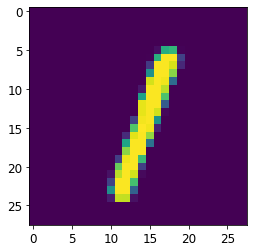

In [101]:
from matplotlib import pyplot as plt
plt.imshow(np.array(test_set_numpy_array[1].reshape(28, 28)), interpolation='nearest')
plt.show()

Let's look at the second image. It should be a 0.

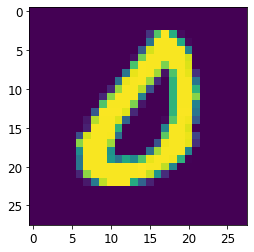

In [102]:
from matplotlib import pyplot as plt
plt.imshow(np.array(test_set_numpy_array[2].reshape(28, 28)), interpolation='nearest')
plt.show()

Looks good!

### Using the gRPC API

In [104]:
from tensorflow_serving.apis.predict_pb2 import PredictRequest

request = PredictRequest()
request.model_spec.name = model_name
request.model_spec.signature_name = "serving_default"
input_name = model.input_names[0]
request.inputs[input_name].CopyFrom(tf.make_tensor_proto(test_set_numpy_array))

In [105]:
import grpc
from tensorflow_serving.apis import prediction_service_pb2_grpc

channel = grpc.insecure_channel('localhost:8500')
predict_service = prediction_service_pb2_grpc.PredictionServiceStub(channel)
response = predict_service.Predict(request, timeout=10.0)

_InactiveRpcError: <_InactiveRpcError of RPC that terminated with:
	status = StatusCode.INVALID_ARGUMENT
	details = "Expects arg[0] to be float but int64 is provided"
	debug_error_string = "{"created":"@1616512646.227664978","description":"Error received from peer ipv6:[::1]:8500","file":"src/core/lib/surface/call.cc","file_line":1061,"grpc_message":"Expects arg[0] to be float but int64 is provided","grpc_status":3}"
>

### Note: OK, I'll skip this part with the gRPC, since REST works and gRPC is used when I want maximum performance.

In [27]:
response

outputs {
  key: "dense_4"
  value {
    dtype: DT_FLOAT
    tensor_shape {
      dim {
        size: 3
      }
      dim {
        size: 10
      }
    }
    float_val: 2.0824443708988838e-05
    float_val: 1.4913139168015732e-08
    float_val: 0.0004813199338968843
    float_val: 0.001888890634290874
    float_val: 2.682592992186983e-07
    float_val: 8.666840585647151e-06
    float_val: 1.6853943241024183e-10
    float_val: 0.9975269436836243
    float_val: 3.833709342870861e-05
    float_val: 3.4738284739432856e-05
    float_val: 0.00017358684272039682
    float_val: 0.0002858016814570874
    float_val: 0.9816810488700867
    float_val: 0.0157401692122221
    float_val: 1.1949770339914068e-10
    float_val: 0.00023017563216853887
    float_val: 3.078056761296466e-05
    float_val: 5.393230750883049e-09
    float_val: 0.0018584482604637742
    float_val: 1.8884094288296183e-09
    float_val: 3.397366526769474e-05
    float_val: 0.9835277795791626
    float_val: 0.001533020636998117


Convert the response to a tensor:

In [28]:
output_name = model.output_names[0]
outputs_proto = response.outputs[output_name]
y_proba = tf.make_ndarray(outputs_proto)
y_proba.round(2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  ],
       [0.  , 0.  , 0.98, 0.02, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.98, 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.  ]],
      dtype=float32)

Or to a NumPy array if your client does not include the TensorFlow library:

In [29]:
output_name = model.output_names[0]
outputs_proto = response.outputs[output_name]
shape = [dim.size for dim in outputs_proto.tensor_shape.dim]
y_proba = np.array(outputs_proto.float_val).reshape(shape)
y_proba.round(2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  ],
       [0.  , 0.  , 0.98, 0.02, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.98, 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.  ]])

## Deploying a new model version

In [107]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28, 1]),
    keras.layers.Dense(50, activation="relu"),
    keras.layers.Dense(50, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-2),
              metrics=["accuracy"])
history = model.fit(train_set.batch(32), epochs=3, validation_data=valid_set.batch(32))

Epoch 1/3
1407/1407 [==============================] - 4s 3ms/step - loss: 15.7676 - accuracy: 0.1134 - val_loss: 2.3079 - val_accuracy: 0.1090
Epoch 2/3
1407/1407 [==============================] - 2s 2ms/step - loss: 2.3012 - accuracy: 0.1135 - val_loss: 2.3080 - val_accuracy: 0.1090
Epoch 3/3
1407/1407 [==============================] - 2s 2ms/step - loss: 2.3012 - accuracy: 0.1135 - val_loss: 2.3080 - val_accuracy: 0.1090


In [108]:
model_version = "0002"
model_name = "my_mnist_model"
model_path = os.path.join(model_name, model_version)
model_path

'my_mnist_model/0002'

In [109]:
tf.saved_model.save(model, model_path)

INFO:tensorflow:Assets written to: my_mnist_model/0002/assets


INFO:tensorflow:Assets written to: my_mnist_model/0002/assets


In [110]:
for root, dirs, files in os.walk(model_name):
    indent = '    ' * root.count(os.sep)
    print('{}{}/'.format(indent, os.path.basename(root)))
    for filename in files:
        print('{}{}'.format(indent + '    ', filename))

my_mnist_model/
    0001/
        saved_model.pb
        variables/
            variables.data-00000-of-00001
            variables.index
        assets/
    0002/
        saved_model.pb
        variables/
            variables.data-00000-of-00001
            variables.index
        assets/


**Warning**: You may need to wait a minute before the new model is loaded by TensorFlow Serving.

In [111]:
import requests

SERVER_URL = 'http://localhost:8501/v1/models/my_mnist_model:predict'
            
response = requests.post(SERVER_URL, data=input_data_json)
response.raise_for_status()
response = response.json()

In [112]:
response.keys()

dict_keys(['predictions'])

In [113]:
y_proba = np.array(response["predictions"])
y_proba.round(2)

array([[0.1 , 0.11, 0.1 , ..., 0.1 , 0.1 , 0.1 ],
       [0.1 , 0.11, 0.1 , ..., 0.1 , 0.1 , 0.1 ],
       [0.1 , 0.11, 0.1 , ..., 0.1 , 0.1 , 0.1 ],
       ...,
       [0.1 , 0.11, 0.1 , ..., 0.1 , 0.1 , 0.1 ],
       [0.1 , 0.11, 0.1 , ..., 0.1 , 0.1 , 0.1 ],
       [0.1 , 0.11, 0.1 , ..., 0.1 , 0.1 , 0.1 ]])

OK. Now let me roll back to the first version of the model. To do this, I'll delete the folder pertaining to the second version of the model and then I'll query the server.

In [114]:
!ls

 01_the_machine_learning_landscape.ipynb
 02_end_to_end_machine_learning_project.ipynb
 03_classification.ipynb
 04_training_linear_models.ipynb
 05_support_vector_machines.ipynb
 06_decision_trees.ipynb
 07_ensemble_learning_and_random_forests.ipynb
 08_dimensionality_reduction.ipynb
 09_unsupervised_learning.ipynb
 10_neural_nets_with_keras.ipynb
 11_training_deep_neural_networks.ipynb
 12_custom_models_and_training_with_tensorflow.ipynb
 13_loading_and_preprocessing_data.ipynb
 14_deep_computer_vision_with_cnns.ipynb
 15_processing_sequences_using_rnns_and_cnns.ipynb
 16_nlp_with_rnns_and_attention.ipynb
 17_autoencoders_and_gans.ipynb
 18_reinforcement_learning.ipynb
 19_training_and_deploying_at_scale.ipynb
 apt.txt
 assets
 book_equations.pdf
 changes_in_2nd_edition.md
 checkpoint
 datasets
 docker
 environment-windows.yml
 environment.yml
 extra_autodiff.ipynb
 extra_gradient_descent_comparison.ipynb
'How to Grid Search Data Preparation Techniques.ipynb'
 images
 index.ipynb
 IN

In [117]:
os.chdir("my_mnist_model")

In [118]:
!ls

0001  0002


In [119]:
!rm -r 0002

In [120]:
!ls

0001


In [121]:
os.chdir("..")

In [122]:
!ls

 01_the_machine_learning_landscape.ipynb
 02_end_to_end_machine_learning_project.ipynb
 03_classification.ipynb
 04_training_linear_models.ipynb
 05_support_vector_machines.ipynb
 06_decision_trees.ipynb
 07_ensemble_learning_and_random_forests.ipynb
 08_dimensionality_reduction.ipynb
 09_unsupervised_learning.ipynb
 10_neural_nets_with_keras.ipynb
 11_training_deep_neural_networks.ipynb
 12_custom_models_and_training_with_tensorflow.ipynb
 13_loading_and_preprocessing_data.ipynb
 14_deep_computer_vision_with_cnns.ipynb
 15_processing_sequences_using_rnns_and_cnns.ipynb
 16_nlp_with_rnns_and_attention.ipynb
 17_autoencoders_and_gans.ipynb
 18_reinforcement_learning.ipynb
 19_training_and_deploying_at_scale.ipynb
 apt.txt
 assets
 book_equations.pdf
 changes_in_2nd_edition.md
 checkpoint
 datasets
 docker
 environment-windows.yml
 environment.yml
 extra_autodiff.ipynb
 extra_gradient_descent_comparison.ipynb
'How to Grid Search Data Preparation Techniques.ipynb'
 images
 index.ipynb
 IN

In [123]:
import requests

SERVER_URL = 'http://localhost:8501/v1/models/my_mnist_model:predict'
            
response = requests.post(SERVER_URL, data=input_data_json)
response.raise_for_status()
response = response.json()

In [124]:
response.keys()

dict_keys(['predictions'])

In [125]:
y_proba = np.array(response["predictions"])
y_proba.round(2)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Model rolled back to the previous version. Great!

Let me now try doing the same thing on Google Cloud:

## Google Cloud

In [7]:
import os
os.chdir("../../../Downloads")
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "cnn-mnist-308715-5e6accf96137.json"

In [32]:
from googleapiclient.discovery import build

project_id = "cnn-mnist-308715" # change this to your project ID
model_id = "cnn_mnist_model"
model_path = "projects/{}/models/{}".format(project_id, model_id)
ml_resource = build("ml", "v1").projects()

In [33]:
def predict(X):
    input_data_json = {"signature_name": "serving_default",
    "instances": X.tolist()}
    request = ml_resource.predict(name=model_path, body=input_data_json)
    response = request.execute()
    if "error" in response:
        raise RuntimeError(response["error"])
    return np.array([pred[output_name] for pred in response["predictions"]])

In [18]:
Y_probas = predict(test_set_numpy_array)

HttpError: <HttpError 400 when requesting https://ml.googleapis.com/v1/projects/cnn-mnist-308715/models/cnn_mnist_model:predict?alt=json returned "Request payload size exceeds the limit: 1572864 bytes.">

In [19]:
print(test_set_numpy_array[0])

[[[  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]]

 [[  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]]

 [[  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]]

 [[  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]]

 [[  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]


In [34]:
Y_probas = predict(test_set_numpy_array[0])

HttpError: <HttpError 404 when requesting https://ml.googleapis.com/v1/projects/cnn-mnist-308715/models/cnn_mnist_model:predict?alt=json returned "Field: name Error: The model resource: "cnn_mnist_model" was not found. Please create the model resource first by using 'gcloud ai-platform models create cnn_mnist_model'.". Details: "[{'@type': 'type.googleapis.com/google.rpc.BadRequest', 'fieldViolations': [{'field': 'name', 'description': 'The model resource: "cnn_mnist_model" was not found. Please create the model resource first by using \'gcloud ai-platform models create cnn_mnist_model\'.'}]}]">

I followed this tutorial (https://cloud.google.com/ai-platform/docs/getting-started-keras) and was able to successfully deploy my model and make predictions.

## 10.

_Exercise: Train any model across multiple GPUs on the same machine using the Mirrored
Strategy (if you do not have access to GPUs, you can use Colaboratory with a
GPU Runtime and create two virtual GPUs). Train the model again using the
CentralStorageStrategy and compare the training time._

I ran this on Google Colab. The Mirrored Strategy ran for 175 seconds, while the Central Storage Strategy ran for 258 seconds.

## 11.

_Exercise: Train a small model on Google Cloud AI Platform, using black box hyperparameter tuning._

I have already done this for the AI Safety Camp, but I can do this again for a small project.

I followed this tutorial: https://cloud.google.com/ai-platform/docs/getting-started-keras